In [ ]:
from meta_info import *
from tools import *
from plot import *
from ntpath import join
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
import os
import math
from preprocessing import *

# 计算抵抗力 ，恢复力

In [ ]:
def calculate_resistance(Deseason_detrend_ndvi, drought_mask, growing_season_mask, spei):
    """
    计算抵抗力 
    公式为: Y_drought_mean-Y_normal_mean
    其中Y是去季节去趋势的ndvi

    """
    # 初始化抵抗力数据集，所有值为NaN
    resistance = xr.full_like(Deseason_detrend_ndvi, np.nan)  

    # Z-score 标准化
    mean_value = Deseason_detrend_ndvi.mean(dim = 'time', skipna = True)
    std_value = Deseason_detrend_ndvi.std(dim = 'time', skipna = True)
    Deseason_detrend_ndvi = (Deseason_detrend_ndvi - mean_value) / std_value
    # 计算正常条件下ndvi均值
    normal_growing_season_mask = growing_season_mask.where(spei >= -0.5)
    normal_growing_season_mean = Deseason_detrend_ndvi.where(normal_growing_season_mask == 1).mean(dim='time', skipna = True)
    # 遍历每个地理位置
    for lat in tqdm(Deseason_detrend_ndvi.lat.values):
        for lon in Deseason_detrend_ndvi.lon.values:
            # 提取单个像元的温度和掩码
            pixel_ndvi = Deseason_detrend_ndvi.sel(lat=lat, lon=lon)
            pixel_drought_mask = drought_mask.sel(lat=lat, lon=lon)
            pixel_ndvi_mean = normal_growing_season_mean.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                # 对每个连续区间计算均值，并替换为resistance
                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_ndvi.time) and pixel_drought_mask[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    region_ndvi = pixel_ndvi.isel(time=slice(int(start_idx), int(end_idx)))  # 提取连续干旱区间的ndvi

                    region_mean = region_ndvi.mean()
                    resistance.loc[{'lat': lat, 'lon': lon, 'time': region_ndvi.time[0]}] = region_mean - pixel_ndvi_mean

    return resistance

def calculate_resilience(Deseason_detrend_ndvi, drought_mask, growing_season_mask, spei):
    """
    计算恢复力 
    公式为: Y_post_mean-Y_normal_mean
    其中Y是去季节去趋势的ndvi

    """
    # 初始化恢复力数据集，所有值为NaN
    resilience = xr.full_like(Deseason_detrend_ndvi, np.nan)  

    # Z-score 标准化
    mean_value = Deseason_detrend_ndvi.mean(dim = 'time', skipna = True)
    std_value = Deseason_detrend_ndvi.std(dim = 'time', skipna = True)
    Deseason_detrend_ndvi = (Deseason_detrend_ndvi - mean_value) / std_value
    # 计算正常条件下ndvi均值
    normal_growing_season_mask = growing_season_mask.where(spei >= -0.5)
    normal_growing_season_mean = Deseason_detrend_ndvi.where(normal_growing_season_mask == 1).mean(dim='time', skipna = True)
    
    # 遍历每个地理位置
    for lat in tqdm(Deseason_detrend_ndvi.lat.values):
        for lon in Deseason_detrend_ndvi.lon.values:
            # 提取单个像元的温度和掩码
            pixel_ndvi = Deseason_detrend_ndvi.sel(lat=lat, lon=lon)
            pixel_drought_mask = drought_mask.sel(lat=lat, lon=lon)
            pixel_growing_season_mask = growing_season_mask.sel(lat=lat, lon=lon)
            pixel_ndvi_mean = normal_growing_season_mean.sel(lat=lat, lon=lon)

            # 计算连续为 1 的区间的索引
            region_indices = np.where(pixel_drought_mask == 1)[0]  # 获取为 1 的位置索引
            if len(region_indices) > 0:
                region_starts = [region_indices[0]]  # 连续区间的起始索引
                for i in range(1, len(region_indices)):
                    if region_indices[i] != region_indices[i-1] + 1:  # 如果不连续，则记录新的起始索引
                        region_starts.append(region_indices[i])

                for start_idx in region_starts:
                    end_idx = start_idx + 1
                    while end_idx < len(pixel_ndvi.time) and pixel_drought_mask[end_idx] == 1:
                        end_idx += 1  # 找到连续区间的结束索引
                    region_ndvi = pixel_ndvi.isel(time=slice(int(start_idx), int(end_idx)))  # 提取生长季的ndvi
                    recovery_time = None
                    for time_idx, ndvi_value in enumerate(pixel_ndvi.sel(time=pixel_ndvi.time[(start_idx + 1):])):
                        if abs(ndvi_value - pixel_ndvi_mean) / pixel_ndvi_mean  <= 0.05:
                            recovery_time = pixel_ndvi.time[(start_idx+1) + time_idx]
                            break
                    # 如果找到恢复时间点，计算该点一年内的生长季平均NDVI
                    if recovery_time is not None:
                        # 计算两个时间点之间的差值，并转换为年份
                        time_diff_years = (pd.to_datetime(recovery_time.values) - pd.to_datetime(pixel_ndvi.time[start_idx].values)).days / 365.25  # 使用365.25来考虑闰年

                        if time_diff_years < 2:
                            one_year_later = pd.to_datetime(recovery_time.values) + pd.DateOffset(years=1)  # 恢复点之后的一年
                            two_years_later = pd.to_datetime(pixel_ndvi.time[start_idx].values) + pd.DateOffset(years=2) # 干旱开始后的两年

                            # 根据 one_year_later 是否在两年内进行选择
                            if one_year_later <= two_years_later:
                                end_time = one_year_later
                            else:
                                end_time = two_years_later
                              # 选取从恢复时间到结束时间的时间范围
                            pixel_ndvi_masked = pixel_ndvi.where(pixel_growing_season_mask == 1)
                            future_growing_season = pixel_ndvi_masked.sel(time=slice(recovery_time, end_time))
                            # 计算平均值
                            average_ndvi_over_year = future_growing_season.mean()

                            # 存储结果
                            resilience.loc[{'lat': lat, 'lon': lon, 'time': region_ndvi.time[0]}] = average_ndvi_over_year - pixel_ndvi_mean         

    return resilience

def run_resistance_resilience(deseason_detrend_ndvi, drought_droped, growing_season_mask, spei, out_fname_list):

    for i in range(len(drought_droped)):
        
        result_drought_resistance=[]
        result_drought_resilience=[]
        drought_resistance = calculate_resistance(deseason_detrend_ndvi, drought_droped[i], growing_season_mask, spei)
        drought_resilience = calculate_resilience(deseason_detrend_ndvi, drought_droped[i], growing_season_mask, spei)
        result_drought_resistance.append(drought_resistance)
        result_drought_resilience.append(drought_resilience)

        drought_resistance.to_netcdf(rf'E:\PHD_Project\New_results\Resistance_resilience\{out_fname_list[i]}_resistance.nc')
        drought_resilience.to_netcdf(rf'E:\PHD_Project\New_results\Resistance_resilience\{out_fname_list[i]}_resilience.nc')  

    return result_drought_resistance, result_drought_resilience

In [ ]:
normal_drought_droped=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_types\normal_drought_droped.nc').ndvi
hot_drought_droped=xr.open_dataset(r'E:\PHD_Project\New_results\Drought_types\hot_drought_droped.nc').ndvi
spei=xr.open_dataset(r'E:\PHD_Project\Data\SPEI\Source\spei03.nc').spei
growing_season_mask=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Growing_season_mask_monthly\Growing_season_mask_monthly_leftrightclear.nc4').ndvi
deseason_detrend_ndvi=xr.open_dataset(r'E:\PHD_Project\Data\GIMMS3g_NDVI\Deseason_detrend\deseason_detrend.nc4').ndvi
# 按月重采样到每月开始, 将时间对齐
spei = spei.resample(time='MS').mean()  # 'MS'表示每月的开始，mean()是一种聚合方法，你可以根据需要选择合适的聚合方法
growing_season_mask = growing_season_mask.resample(time='MS').mean()
# 截取ndvi同等时间段
spei = spei.sel(time=growing_season_mask.time)

In [ ]:
out_fname_list=['normal_drought', 'hot_drought']
drought_droped = [normal_drought_droped, hot_drought_droped]

In [ ]:
result_drought_resistance, result_drought_resilience = run_resistance_resilience(deseason_detrend_ndvi, drought_droped, growing_season_mask, spei, out_fname_list)

d:\Anaconda\envs\biodiversity\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/360 [00:00<?, ?it/s]

d:\Anaconda\envs\biodiversity\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/360 [00:00<?, ?it/s]

d:\Anaconda\envs\biodiversity\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/360 [00:00<?, ?it/s]

d:\Anaconda\envs\biodiversity\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


  0%|          | 0/360 [00:00<?, ?it/s]

# 可视化

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

def plot_2d(dataset, cmap='coolwarm', vmax=None, vmin=None):
    # 设定断点
    boundaries = [-1.5, -0.1, 0, 0.05, 0.1, 1.5]  # 定义颜色断点
    # 创建归一化对象，使用上面定义的断点
    norm = BoundaryNorm(boundaries, ncolors=256, extend='both')

    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()})

    # 绘制数据
    dataset.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,add_colorbar=True, vmax=vmax , vmin=vmin, cbar_kwargs={'label': ''})

    #隐藏tittle
    ax.set_title('')

    # 添加海岸线
    ax.coastlines()

    # 添加经纬度网格，但不显示网格线
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='none', alpha=0)
    # gl.top_labels = False
    # gl.bottom_labels = False
    # gl.left_labels = False
    # gl.right_labels = False
    gl.xlines = False
    gl.ylines = False

In [ ]:
normal_drought_resistance=xr.open_dataset(r'E:\PHD_Project\New_results\Resistance_resilience\normal_drought_resistance.nc').ndvi
normal_drought_resilience=xr.open_dataset(r'E:\PHD_Project\New_results\Resistance_resilience\normal_drought_resilience.nc').ndvi
hot_drought_resistance=xr.open_dataset(r'E:\PHD_Project\New_results\Resistance_resilience\hot_drought_resistance.nc').ndvi
hot_drought_resilience=xr.open_dataset(r'E:\PHD_Project\New_results\Resistance_resilience\hot_drought_resilience.nc').ndvi

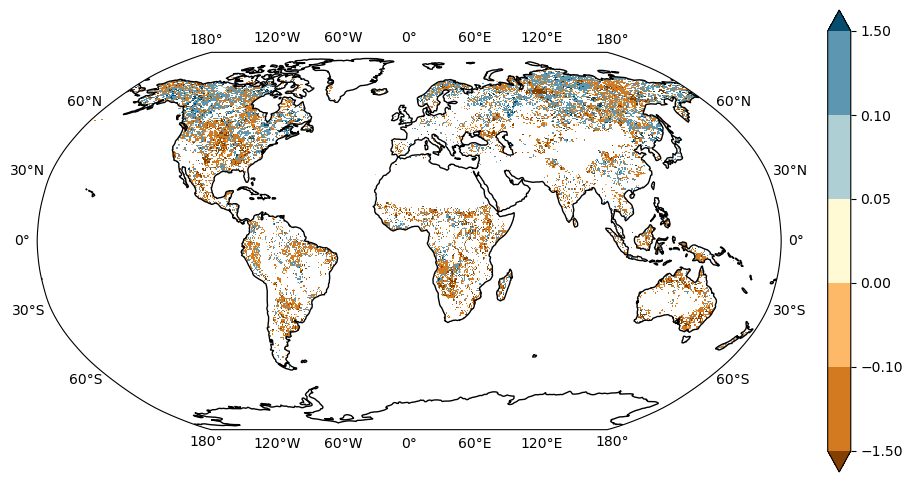

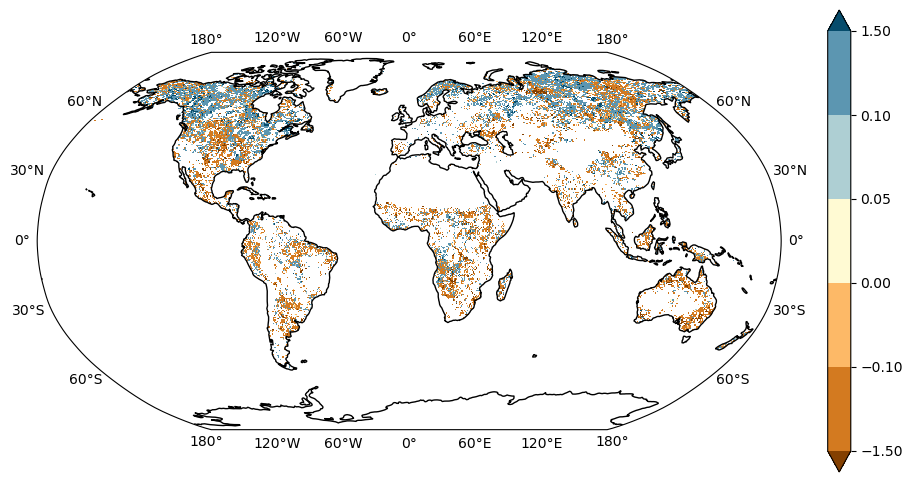

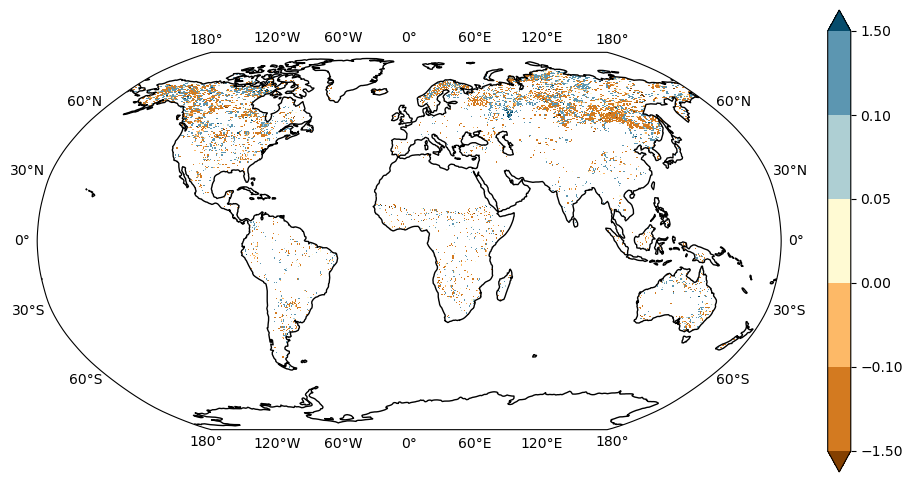

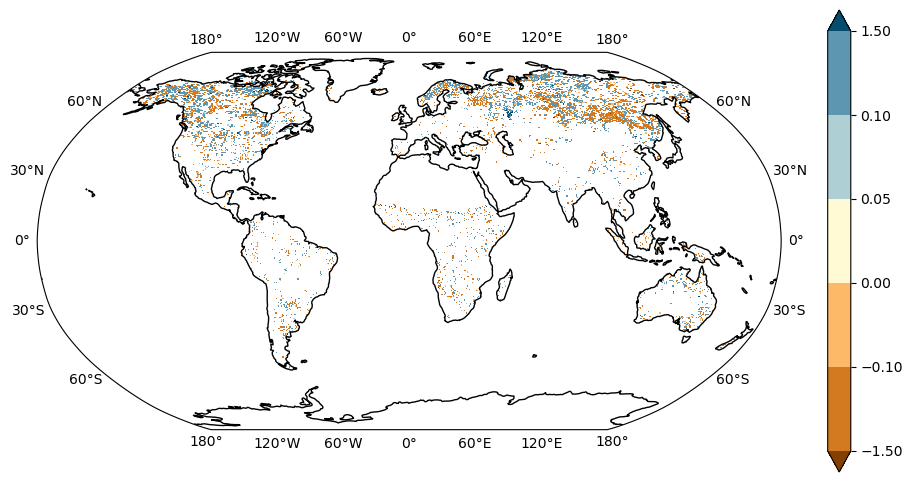

In [ ]:
plot_2d(normal_drought_resistance.min(dim = 'time'), cmap= global_cmap)
plot_2d(normal_drought_resistance.mean(dim = 'time'), cmap= global_cmap)
plot_2d(normal_drought_resilience.min(dim = 'time'), cmap= global_cmap)
plot_2d(normal_drought_resilience.mean(dim = 'time'), cmap= global_cmap)

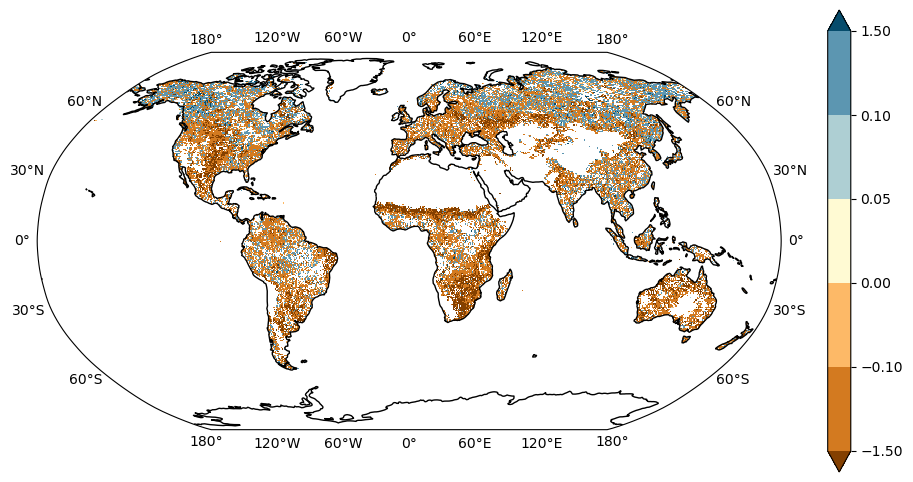

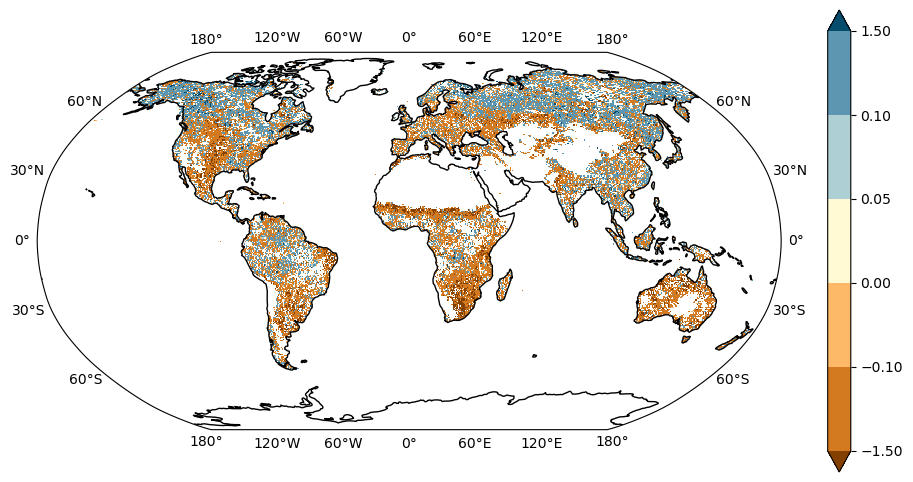

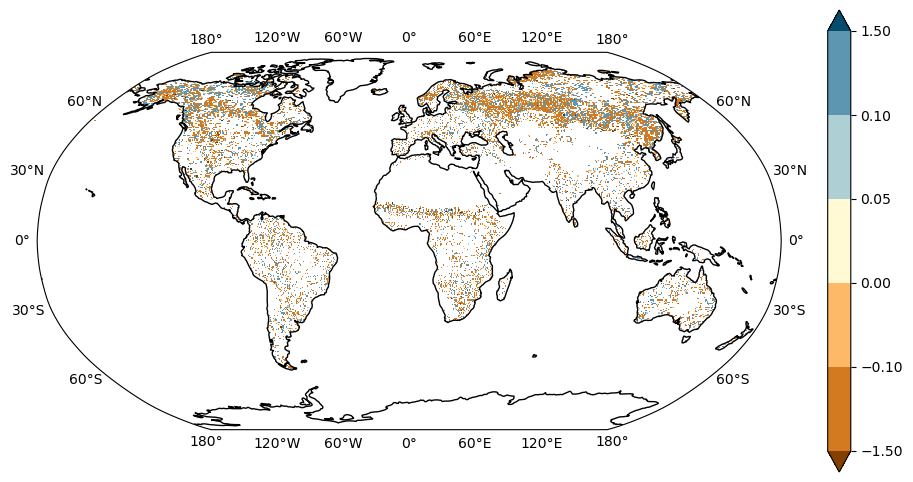

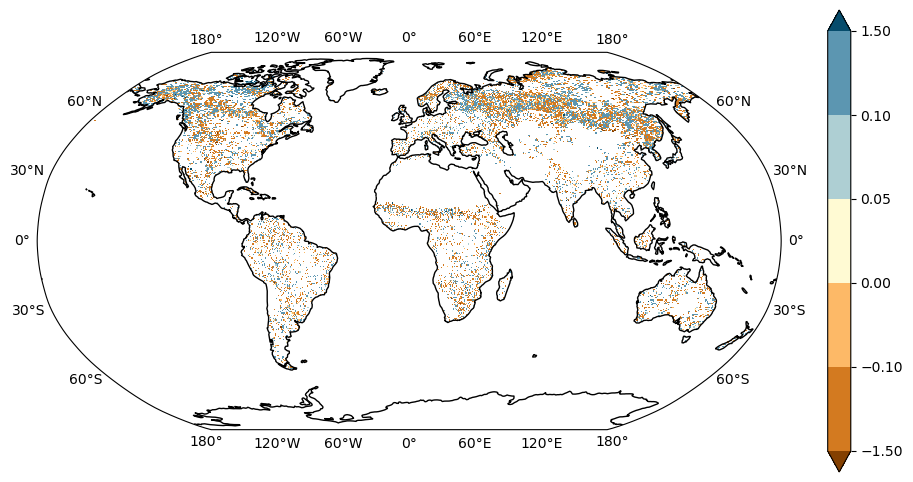

In [ ]:
plot_2d(hot_drought_resistance.min(dim = 'time'), cmap= global_cmap)
plot_2d(hot_drought_resistance.mean(dim = 'time'), cmap= global_cmap)
plot_2d(hot_drought_resilience.min(dim = 'time'), cmap= global_cmap)
plot_2d(hot_drought_resilience.mean(dim = 'time'), cmap= global_cmap)